# 如何从图表中流式传输 LLM 代币

在这个例子中，我们将从语言模型中流式传输令牌，为
代理人。我们将使用 ReAct 代理作为示例。

<div class="警告信息">
<p class="admonition-title">注意</p>
<p>
如果您使用的是 <code>@langchain/core</code> < 0.2.3 版本，则在调用聊天模型或 LLM 时，您需要在节点内调用 <code>await model.stream()</code> 以获取逐个令牌的流事件，并根据需要聚合最终输出以更新图形状态。在 <code>@langchain/core</code> 的更高版本中，这种情况会自动发生，您可以调用 <code>await model.invoke()</code>。
<br>
有关如何升级 <code>@langchain/core</code> 的更多信息，请查看<a href="https://js.langchain.com/docs/how_to/installation/#installing-integration-packages">此处的说明</a>。
</p>
</div>

本操作指南紧随本目录中的其他指南，展示了如何
将功能合并到 LangGraph 中的原型代理中。

<div class="警告信息">
<p class="admonition-title">流媒体支持</p>
<p>
许多（但并非所有）聊天模型都支持令牌流。<a href="https://js.langchain.com/docs/integrations/chat/">此处 (doc)</a> 检查您的 LLM 集成是否支持令牌流。请注意，某些集成可能支持<i>通用</i>令牌流，但缺乏对流工具调用的支持。
</p>
</div>

<div class="警告提示">
<p class="admonition-title">注意</p>
<p>
在本指南中，我们将从头开始创建透明（但冗长）的代理。您可以使用 <code>createReactAgent({ llm, tools })</code> (<a href="/langgraphjs/reference/functions/langgraph_prebuilt.createReactAgent.html">API doc</a>) 构造函数完成类似的功能。如果你习惯了 LangChain 的 <a href="https://js.langchain.com/docs/how_to/agent_executor">AgentExecutor</a> 类，这可能更合适。
</p>
</div>

## 设置

本指南将使用 OpenAI 的 GPT-4o 模型。我们可以选择设置 API 密钥
对于 [LangSmith 追踪](https://smith.langchain.com/)，这将为我们提供
一流的可观测性。

---

In [1]:
// process.env.OPENAI_API_KEY = "sk_...";

// 可选，在 LangSmith 中添加跟踪
// process.env.LANGCHAIN_API_KEY = "ls__...";
// process.env.LANGCHAIN_CALLBACKS_BACKGROUND = "true";
// process.env.LANGCHAIN_TRACING = "true";
// process.env.LANGCHAIN_PROJECT = "流代币：LangGraphJS";

## 定义状态

状态是图中所有节点的接口。


In [2]:
import { Annotation } from "@langchain/langgraph";
import type { BaseMessageLike } from "@langchain/core/messages";

const StateAnnotation = Annotation.Root({
  messages: Annotation<BaseMessageLike[]>({
    reducer: (x, y) => x.concat(y),
  }),
});

## 设置工具

首先定义您要使用的工具。对于这个简单的示例，我们将创建一个占位符搜索引擎，但请参阅[此处](https://js.langchain.com/docs/how_to/custom_tools)有关如何创建您自己的自定义工具的文档。

In [3]:
import { tool } from "@langchain/core/tools";
import { z } from "zod";

const searchTool = tool((_) => {
  // 这是实际实现的占位符
  return "Cold, with a low of 3℃";
}, {
  name: "search",
  description:
    "Use to surf the web, fetch current information, check the weather, and retrieve other information.",
  schema: z.object({
    query: z.string().describe("The query to use in your search."),
  }),
});

await searchTool.invoke({ query: "What's the weather like?" });

const tools = [searchTool];

我们现在可以将这些工具包装在预构建的中
[ToolNode](/langgraphjs/reference/classes/langgraph_prebuilt.ToolNode.html)。
每当工具（函数）被调用时，该对象就会实际运行它们
我们的法学硕士。

In [4]:
import { ToolNode } from "@langchain/langgraph/prebuilt";

const toolNode = new ToolNode(tools);

## 设置模型

现在加载[聊天模型](https://js.langchain.com/docs/concepts/#chat-models)。

1.它应该与消息一起使用。我们将以表格形式代表所有代理状态
消息，因此它需要能够与它们很好地配合。
2.它应该与
[工具调用](https://js.langchain.com/docs/how_to/tool_calling/#passing-tools-to-llms),
这意味着它可以在响应中返回函数参数。

<div class="警告提示">
<p class="admonition-title">注意</p>
<p>
这些模型要求不是使用 LangGraph 的一般要求 - 它们只是这个示例的要求。
</p>
</div>

In [5]:
import { ChatOpenAI } from "@langchain/openai";

const model = new ChatOpenAI({
  model: "gpt-4o-mini",
  temperature: 0,
});

完成此操作后，我们应该确保模型知道它具有这些
可供调用的工具。我们可以通过调用来做到这一点
[bindTools](https://v01.api.js.langchain.com/classes/langchain_core_language_models_chat_models.BaseChatModel.html#bindTools)。

In [7]:
const boundModel = model.bindTools(tools);

## 定义图表

我们现在可以把它们放在一起。

In [8]:
import { StateGraph, END } from "@langchain/langgraph";
import { AIMessage } from "@langchain/core/messages";

const routeMessage = (state: typeof StateAnnotation.State) => {
  const { messages } = state;
  const lastMessage = messages[messages.length - 1] as AIMessage;
  // 如果没有调用任何工具，我们就可以完成（响应用户）
  if (!lastMessage?.tool_calls?.length) {
    return END;
  }
  // 否则，如果有，我们继续并调用工具
  return "tools";
};

const callModel = async (
  state: typeof StateAnnotation.State,
) => {
  // 对于 @langchain/core < 0.2.3 的版本，您必须调用 `.stream()`
  // 并从块聚合消息而不是调用“.invoke()”。
  const { messages } = state;
  const responseMessage = await boundModel.invoke(messages);
  return { messages: [responseMessage] };
};

const workflow = new StateGraph(StateAnnotation)
  .addNode("agent", callModel)
  .addNode("tools", toolNode)
  .addEdge("__start__", "agent")
  .addConditionalEdges("agent", routeMessage)
  .addEdge("tools", "agent");

const agent = workflow.compile();

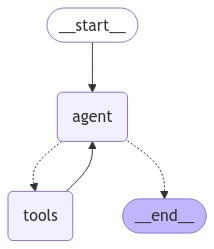

In [9]:
import * as tslab from "tslab";

const runnableGraph = agent.getGraph();
const image = await runnableGraph.drawMermaidPng();
const arrayBuffer = await image.arrayBuffer();

await tslab.display.png(new Uint8Array(arrayBuffer));

## 流媒体 LLM 代币

您可以使用两种方法访问每个节点生成的 LLM 令牌：

- `stream` 方法以及 `streamMode: "messages"`
- `streamEvents` 方法

### 流方法

<div class="警告提示">
<p class="admonition-title">兼容性</p>
<p>
此部分需要 <code>@langchain/langgraph>=0.2.20</code>。如需升级帮助，请参阅<a href="/langgraphjs/how-tos/manage-ecosystem-dependencies/">本指南</a>。
</p>
</div>

对于此方法，您必须使用也支持流式传输的 LLM（例如 `new ChatOpenAI({ model: "gpt-4o-mini" })`）或在内部 LLM 调用上调用 `.stream`。

In [10]:
import { isAIMessageChunk } from "@langchain/core/messages";

const stream = await agent.stream(
  { messages: [{ role: "user", content: "What's the current weather in Nepal?" }] },
  { streamMode: "messages" },
);

for await (const [message, _metadata] of stream) {
  if (isAIMessageChunk(message) && message.tool_call_chunks?.length) {
    console.log(`${message.getType()} MESSAGE TOOL CALL CHUNK: ${message.tool_call_chunks[0].args}`);
  } else {
    console.log(`${message.getType()} MESSAGE CONTENT: ${message.content}`);
  }
}

ai MESSAGE TOOL CALL CHUNK: 
ai MESSAGE TOOL CALL CHUNK: {"
ai MESSAGE TOOL CALL CHUNK: query
ai MESSAGE TOOL CALL CHUNK: ":"
ai MESSAGE TOOL CALL CHUNK: current
ai MESSAGE TOOL CALL CHUNK:  weather
ai MESSAGE TOOL CALL CHUNK:  in
ai MESSAGE TOOL CALL CHUNK:  Nepal
ai MESSAGE TOOL CALL CHUNK: "}
ai MESSAGE CONTENT: 
tool MESSAGE CONTENT: Cold, with a low of 3℃
ai MESSAGE CONTENT: 
ai MESSAGE CONTENT: The
ai MESSAGE CONTENT:  current
ai MESSAGE CONTENT:  weather
ai MESSAGE CONTENT:  in
ai MESSAGE CONTENT:  Nepal
ai MESSAGE CONTENT:  is
ai MESSAGE CONTENT:  cold
ai MESSAGE CONTENT: ,
ai MESSAGE CONTENT:  with
ai MESSAGE CONTENT:  a
ai MESSAGE CONTENT:  low
ai MESSAGE CONTENT:  temperature
ai MESSAGE CONTENT:  of
ai MESSAGE CONTENT:  
ai MESSAGE CONTENT: 3
ai MESSAGE CONTENT: ℃
ai MESSAGE CONTENT: .
ai MESSAGE CONTENT: 


### 禁用流媒体

如果您希望禁用给定节点或模型调用的流式传输，您可以添加 `"nostream"` 标签。下面是一个示例，其中我们添加了一个带有 LLM 调用的初始节点，该调用不会在最终输出中进行流式传输：

In [13]:
import { RunnableLambda } from "@langchain/core/runnables";

const unstreamed = async (_: typeof StateAnnotation.State) => {
  const model = new ChatOpenAI({
    model: "gpt-4o-mini",
    temperature: 0,
  });
  const res = await model.invoke("How are you?");
  console.log("LOGGED UNSTREAMED MESSAGE", res.content);
  // 不要更新状态，这只是为了显示不会流式传输的呼叫
  return {};
}

const agentWithNoStream = new StateGraph(StateAnnotation)
  .addNode("unstreamed",
    // 给整个节点添加“nostream”标签
    RunnableLambda.from(unstreamed).withConfig({
      tags: ["nostream"]
    })
  )
  .addNode("agent", callModel)
  .addNode("tools", toolNode)
  // 在代理之前运行非流式节点
  .addEdge("__start__", "unstreamed")
  .addEdge("unstreamed", "agent")
  .addConditionalEdges("agent", routeMessage)
  .addEdge("tools", "agent")
  .compile();

const stream = await agentWithNoStream.stream(
  { messages: [{ role: "user", content: "What's the current weather in Nepal?" }] },
  { streamMode: "messages" },
);

for await (const [message, _metadata] of stream) {
  if (isAIMessageChunk(message) && message.tool_call_chunks?.length) {
    console.log(`${message.getType()} MESSAGE TOOL CALL CHUNK: ${message.tool_call_chunks[0].args}`);
  } else {
    console.log(`${message.getType()} MESSAGE CONTENT: ${message.content}`);
  }
}

LOGGED UNSTREAMED MESSAGE I'm just a computer program, so I don't have feelings, but I'm here and ready to help you! How can I assist you today?
ai MESSAGE TOOL CALL CHUNK: 
ai MESSAGE TOOL CALL CHUNK: {"
ai MESSAGE TOOL CALL CHUNK: query
ai MESSAGE TOOL CALL CHUNK: ":"
ai MESSAGE TOOL CALL CHUNK: current
ai MESSAGE TOOL CALL CHUNK:  weather
ai MESSAGE TOOL CALL CHUNK:  in
ai MESSAGE TOOL CALL CHUNK:  Nepal
ai MESSAGE TOOL CALL CHUNK: "}
ai MESSAGE CONTENT: 
tool MESSAGE CONTENT: Cold, with a low of 3℃
ai MESSAGE CONTENT: 
ai MESSAGE CONTENT: The
ai MESSAGE CONTENT:  current
ai MESSAGE CONTENT:  weather
ai MESSAGE CONTENT:  in
ai MESSAGE CONTENT:  Nepal
ai MESSAGE CONTENT:  is
ai MESSAGE CONTENT:  cold
ai MESSAGE CONTENT: ,
ai MESSAGE CONTENT:  with
ai MESSAGE CONTENT:  a
ai MESSAGE CONTENT:  low
ai MESSAGE CONTENT:  temperature
ai MESSAGE CONTENT:  of
ai MESSAGE CONTENT:  
ai MESSAGE CONTENT: 3
ai MESSAGE CONTENT: ℃
ai MESSAGE CONTENT: .
ai MESSAGE CONTENT: 


如果从 `"unstreamed"` 节点中删除标签，则其中模型调用的结果也将出现在最终流中。

### StreamEvents 方法

您还可以使用 `streamEvents` 方法，如下所示：

In [14]:
const eventStream = agent.streamEvents(
  { messages: [{ role: "user", content: "What's the weather like today?" }] },
  { version: "v2" },
);

for await (const { event, data } of eventStream) {
  if (event === "on_chat_model_stream" && isAIMessageChunk(data.chunk)) {
    if (
      data.chunk.tool_call_chunks !== undefined &&
      data.chunk.tool_call_chunks.length > 0
    ) {
      console.log(data.chunk.tool_call_chunks);
    }
  }
}

[
  {
    name: 'search',
    args: '',
    id: 'call_Qpd6frHt0yUYWynRbZEXF3le',
    index: 0,
    type: 'tool_call_chunk'
  }
]
[
  {
    name: undefined,
    args: '{"',
    id: undefined,
    index: 0,
    type: 'tool_call_chunk'
  }
]
[
  {
    name: undefined,
    args: 'query',
    id: undefined,
    index: 0,
    type: 'tool_call_chunk'
  }
]
[
  {
    name: undefined,
    args: '":"',
    id: undefined,
    index: 0,
    type: 'tool_call_chunk'
  }
]
[
  {
    name: undefined,
    args: 'current',
    id: undefined,
    index: 0,
    type: 'tool_call_chunk'
  }
]
[
  {
    name: undefined,
    args: ' weather',
    id: undefined,
    index: 0,
    type: 'tool_call_chunk'
  }
]
[
  {
    name: undefined,
    args: ' today',
    id: undefined,
    index: 0,
    type: 'tool_call_chunk'
  }
]
[
  {
    name: undefined,
    args: '"}',
    id: undefined,
    index: 0,
    type: 'tool_call_chunk'
  }
]
